In [2]:
import pandas as pd
import numpy as np
#data = pd.read_csv('data/Compressed Mortality, 2016.txt', sep=" ", header=None)
#data.columns = ["a", "b", "c", "etc."]
#data = pd.read_fwf('data/Compressed Mortality, 2016.txt')


from os import listdir
from os.path import isfile, join

import matplotlib.pyplot as plt
% matplotlib inline

import glob
import os

In [3]:
# Compressed Mortality

# get a list of the data files the direction
onlyfiles = [f for f in listdir('data/Compressed Mortality/') if isfile(join('data/Compressed Mortality/', f))]
print(onlyfiles)

# for each txt file...
for i in np.arange(len(onlyfiles)):

    data_temp = pd.read_table('data/Compressed Mortality/' + onlyfiles[i], header='infer', index_col=None,  names=('Notes', 'County', 'County Code', 'Deaths', 'Population', 'Crude Rate'))
    #data_temp.drop(data_temp.index[0])
    data_dropped = data_temp.iloc[1:] #Remove the first row because it's the files's header
    data_dropped['County Code'] = pd.to_numeric(data_dropped['County Code']) # Make the zipcode a float instead of a string
    #print(data_dropped.head(5))

    data_dropped.insert(0, 'year', int(onlyfiles[i][-8:-4])) # Add the year as a column
#print(data.head)
    if i == 0:
        data = data_dropped
    else:
        data = pd.concat([data, data_dropped]) # add each year's text file to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year']) # put in order

#print(data_sorted.head(5))

data_mortality = data_sorted


data_mortality.set_index(['County Code', 'year'], inplace=True, drop =False)


temp = np.zeros((data_mortality.shape[0],1))
unreliable = np.zeros((data_mortality.shape[0],1))
for i in range(data_mortality.shape[0]):
    
    
    #print(data['Crude Rate'].iloc[i])
    #s = re.findall('\d*\.?\d+', data['Crude Rate'].iloc[i])
    try:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i].split()[0])
        unreliable[i] = 1
    except:
        temp[i] = float(data_mortality['Crude Rate'].iloc[i])
        unreliable[i] = 0
        
data_mortality['Crude Rate'] =temp
#data = data.assign(unreliable_deat_rate=unreliable)


#data.plot(kind='scatter', x='Opioid Perscription Rate', y='Crude Rate')

#print(data_mortality.head(20))

#print(data.iloc[2000])

['Compressed Mortality, 2010.txt', 'Compressed Mortality, 2004.txt', 'Compressed Mortality, 2005.txt', 'Compressed Mortality, 2011.txt', 'Compressed Mortality, 2007.txt', 'Compressed Mortality, 2013.txt', 'Compressed Mortality, 2012.txt', 'Compressed Mortality, 2006.txt', 'Compressed Mortality, 2002.txt', 'Compressed Mortality, 2016.txt', 'Compressed Mortality, 2003.txt', 'Compressed Mortality, 2015.txt', 'Compressed Mortality, 2001.txt', 'Compressed Mortality, 2000.txt', 'Compressed Mortality, 2014.txt', 'Compressed Mortality, 1999.txt', 'Compressed Mortality, 2008.txt', 'Compressed Mortality, 2009.txt']


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [4]:
# perscrption drugs

# Get all the relevant csv files
onlyfiles = [f for f in listdir('data/Prescriptions/') if isfile(join('data/Prescriptions/', f))]

print(onlyfiles)

# For all the files...
for i in np.arange(len(onlyfiles)):
    # load the CSV
    data_temp = pd.read_csv('data/Prescriptions/' + onlyfiles[i], index_col=None,  names=('State', 'County Code', 'Opioid Perscription Rate'))
    
    # Insert the year as a column in the dataframe
    data_temp.insert(0, 'year', int(onlyfiles[i][-8:-4]))
#print(data.head)
    if i == 0:
        data = data_temp
    else:
        data = pd.concat([data, data_temp]) # Add to the overall dataframe


data_sorted = data.sort_values(by=['County Code', 'year'])


data_perscriptions = data_sorted

data_perscriptions.set_index(['County Code', 'year'], inplace=True, drop =False)

['rxrate_2006.csv', 'rxrate_2012.csv', 'rxrate_2013.csv', 'rxrate_2007.csv', 'rxrate_2011.csv', 'rxrate_2010.csv', 'rxrate_2014.csv', 'rxrate_2015.csv', 'rxrate_2016.csv', 'rxrate_2009.csv', 'rxrate_2008.csv']


In [5]:
# county health statistics

def create_fips_code(df):
    fips_code = []
    for i in range(df['statecode'].shape[0]):
        # combine the statecode and countycode to create the fips_code
        string = '{:d}{:03d}'.format(df['statecode'].iloc[i], df['countycode'].iloc[i])
        fips_code.append(int(string)) 
    return fips_code

# load all data into a single dataframe
data_dir = 'data/county health rankings'
file_wildcard = os.path.join(data_dir, '*.csv')
for i, filepath in enumerate(reversed(glob.glob(file_wildcard))):
    year = filepath.split('/')[-1].split('\\')[-1].split(' ')[0]
    print(i, filepath, year)
    
    # load the data
    data = pd.read_csv(filepath)
    # convert all columns to lower case
    data.columns = map(str.lower, data.columns)
    # calculate the fips_code and insert as 1st column
    data.insert(loc=0, column='County Code', value=create_fips_code(data))
    # insert the year as the 2nd column
    data.insert(loc=1, column='year', value=int(year))
    #
    if i == 0:
        df = data
        orig_columns = data.columns
    else:
        df = pd.concat([df, data])
    print(data.shape)

    
print(df.shape)

data_health_statistics = df
#data_health_statistics.rename(columns = {'5-digit fips code':'County Code'}, inplace = True)


data_health_statistics = data_health_statistics.sort_values(by=['County Code', 'year'])

data_health_statistics.set_index(['County Code', 'year'], inplace=True, drop =False)

0 data/county health rankings/2017 CHR analytic data.csv 2017
(3186, 358)
1 data/county health rankings/2015 CHR analytic data.csv 2015
(3191, 331)
2 data/county health rankings/2016 CHR analytic data.csv 2016
(3191, 356)
3 data/county health rankings/2014 CHR analytic data.csv 2014
(3191, 326)
(12759, 373)


In [6]:
data_health_statistics.iloc[10]

5-digit fips code                                                  NaN
County Code                                                       1003
access to exercise opportunities denominator                       NaN
access to exercise opportunities lower confidence interval         NaN
access to exercise opportunities numerator                         NaN
access to exercise opportunities upper confidence interval         NaN
access to exercise opportunities value                           0.722
adult obesity denominator                                       143240
adult obesity lower confidence interval                          0.238
adult obesity numerator                                          38245
adult obesity upper confidence interval                          0.297
adult obesity value                                              0.267
adult smoking denominator                                          NaN
adult smoking lower confidence interval                           0.18
adult 

In [7]:
# combine the three dataframes

data_temp = data_mortality.join(data_perscriptions, how ='outer', lsuffix = '_data_mortality', rsuffix = '_data_perscriptions')

data = data_temp.join(data_health_statistics, how = 'outer', lsuffix = '_data', rsuffix = '_data_health_statistics')

data.head(15)


year_data_mortality Notes County  \
County Code year                                     
1000        2014                  NaN   NaN    NaN   
            2015                  NaN   NaN    NaN   
            2016                  NaN   NaN    NaN   
            2017                  NaN   NaN    NaN   
1001        2006                  NaN   NaN    NaN   
            2007                  NaN   NaN    NaN   
            2008                  NaN   NaN    NaN   
            2009                  NaN   NaN    NaN   
            2010                  NaN   NaN    NaN   
            2011                  NaN   NaN    NaN   
            2012                  NaN   NaN    NaN   
            2013                  NaN   NaN    NaN   
            2014                  NaN   NaN    NaN   
            2015                  NaN   NaN    NaN   
            2016                  NaN   NaN    NaN   

                  County Code_data_mortality Deaths Population  Crude Rate  \
County Code year                                                             
1000        2014                         NaN    NaN        NaN         NaN   
            2015                         NaN    NaN        NaN         NaN   
            2016                         NaN    NaN        NaN         NaN   
            2017                         NaN    NaN        NaN         NaN   
1001        2006                         NaN    NaN        NaN         NaN   
            2007                         NaN    NaN        NaN         NaN   
            2008                         NaN    NaN        NaN         NaN   
            2009                         NaN    NaN        NaN         NaN   
            2010                         NaN    NaN        NaN         NaN   
            2011                         NaN    NaN        NaN         NaN   
            2012                         NaN    NaN        NaN         NaN   
            2013                         NaN    NaN        NaN         NaN   
            2014                         NaN    NaN        NaN         NaN   
            2015                         NaN    NaN        NaN         NaN   
            2016                         NaN    NaN        NaN         NaN   

                  year_data_perscriptions State  \
County Code year                                  
1000        2014                      NaN   NaN   
            2015                      NaN   NaN   
            2016                      NaN   NaN   
            2017                      NaN   NaN   
1001        2006                   2006.0    AL   
            2007                   2007.0    AL   
            2008                   2008.0    AL   
            2009                   2009.0    AL   
            2010                   2010.0    AL   
            2011                   2011.0    AL   
            2012                   2012.0    AL   
            2013                   2013.0    AL   
            2014                   2014.0    AL   
            2015                   2015.0    AL   
            2016                   2016.0    AL   

                  County Code_data_perscriptions   ...    \
County Code year                                   ...     
1000        2014                             NaN   ...     
            2015                             NaN   ...     
            2016                             NaN   ...     
            2017                             NaN   ...     
1001        2006                          1001.0   ...     
            2007                          1001.0   ...     
            2008                          1001.0   ...     
            2009                          1001.0   ...     
            2010                          1001.0   ...     
            2011                          1001.0   ...     
            2012                          1001.0   ...     
            2013                          1001.0   ...     
            2014                          1001.0   ...     
    

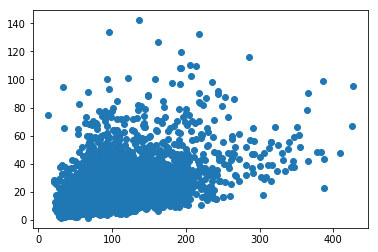

In [8]:
plt.figure()
plt.scatter(data['Opioid Perscription Rate'], data['Crude Rate'])


In [9]:
data

year_data_mortality Notes              County  \
County Code year                                                  
1000        2014                  NaN   NaN                 NaN   
            2015                  NaN   NaN                 NaN   
            2016                  NaN   NaN                 NaN   
            2017                  NaN   NaN                 NaN   
1001        2006                  NaN   NaN                 NaN   
            2007                  NaN   NaN                 NaN   
            2008                  NaN   NaN                 NaN   
            2009                  NaN   NaN                 NaN   
            2010                  NaN   NaN                 NaN   
            2011                  NaN   NaN                 NaN   
            2012                  NaN   NaN                 NaN   
            2013                  NaN   NaN                 NaN   
            2014                  NaN   NaN                 NaN   
            2015                  NaN   NaN                 NaN   
            2016                  NaN   NaN                 NaN   
            2017                  NaN   NaN                 NaN   
1003        1999               1999.0   NaN  Baldwin County, AL   
            2000               2000.0   NaN  Baldwin County, AL   
            2001               2001.0   NaN  Baldwin County, AL   
            2002               2002.0   NaN  Baldwin County, AL   
            2003               2003.0   NaN  Baldwin County, AL   
            2004               2004.0   NaN  Baldwin County, AL   
            2005               2005.0   NaN  Baldwin County, AL   
            2006               2006.0   NaN  Baldwin County, AL   
            2007               2007.0   NaN  Baldwin County, AL   
            2008               2008.0   NaN  Baldwin County, AL   
            2009               2009.0   NaN  Baldwin County, AL   
            2010               2010.0   NaN  Baldwin County, AL   
            2011               2011.0   NaN  Baldwin County, AL   
            2012               2012.0   NaN  Baldwin County, AL   
...                               ...   ...                 ...   
56041       2012                  NaN   NaN                 NaN   
            2013                  NaN   NaN                 NaN   
            2014                  NaN   NaN                 NaN   
            2015                  NaN   NaN                 NaN   
            2016                  NaN   NaN                 NaN   
            2017                  NaN   NaN                 NaN   
56043       2006                  NaN   NaN                 NaN   
            2007                  NaN   NaN                 NaN   
            2008                  NaN   NaN                 NaN   
            2009                  NaN   NaN                 NaN   
            2010                  NaN   NaN                 NaN   
            2011                  NaN   NaN                 NaN   
            2012                  NaN   NaN                 NaN   
            2013                  NaN   NaN                 NaN   
            2014                  NaN   NaN                 NaN   
            2015                  NaN   NaN                 NaN   
            2016                  NaN   NaN                 NaN   
            2017                  NaN   NaN                 NaN   
56045       2006                  NaN   NaN                 NaN   
            2007                  NaN   NaN                 NaN   
            2008                  NaN   NaN                 NaN   
            2009                  NaN   NaN                 NaN   
            2010                  NaN   NaN                 NaN   
            2011                  NaN   NaN                 NaN   
            2012                  NaN   NaN                 NaN   
            2013                  NaN   NaN                 NaN   
            2014                  NaN   NaN                 NaN  

           Crude Rate
statecode            
1.0             369.0
2.0              73.1
4.0             207.6
5.0             164.0
6.0             788.3
8.0             187.9
9.0             165.3
10.0             61.4
11.0             14.6
12.0            535.6
13.0            517.8
15.0             36.5
16.0            113.5
17.0            480.6
18.0            628.3
19.0             93.6
20.0             95.1
21.0           1016.0
22.0            346.1
23.0            140.4
24.0            385.8
25.0            232.8
26.0            443.7
27.0            112.0
28.0             82.0
29.0            384.9
30.0             37.7
31.0             22.7
32.0            106.3
33.0            205.4
34.0            310.8
35.0            359.0
36.0            507.5
37.0            780.4
38.0              7.2
39.0           1252.8
40.0            526.2
41.0            212.7
42.0            943.1
44.0             99.7
45.0            293.2
46.0              9.3
47.0            925.3
48.0      

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


Text(0,0.5,'2015-2016 perc change in deaths')

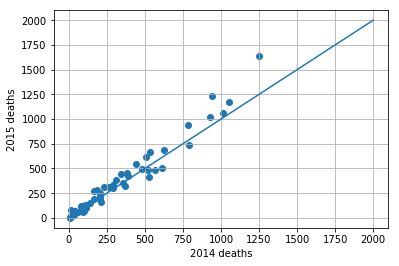

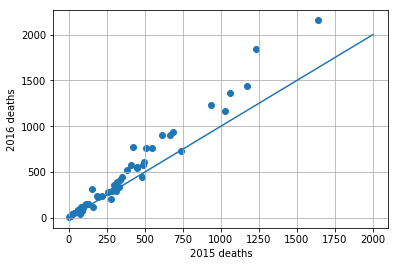

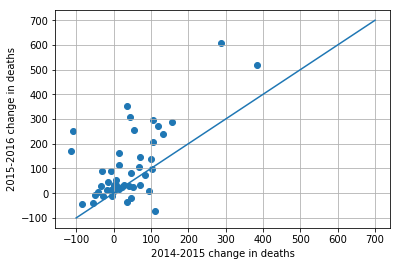

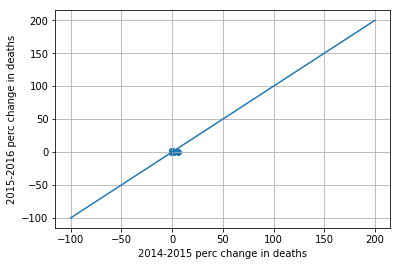

In [44]:
#data.loc[1003]

df14 = data[['statecode', 'Crude Rate']][data['year']==2014]
df15 = data[['statecode', 'Crude Rate']][data['year']==2015]
df16 = data[['statecode', 'Crude Rate']][data['year']==2016]

df14_statesum = df14.groupby('statecode').sum()
df15_statesum = df15.groupby('statecode').sum()
df16_statesum = df16.groupby('statecode').sum()

diff1514 = df15_statesum-df14_statesum
diff1615 = df16_statesum-df15_statesum

diff1514_perc = np.divide(diff1514, df14_statesum)
diff1615_perc = np.divide(diff1615, df15_statesum)

print(df14_statesum)

plt.figure()
plt.scatter(df14_statesum, df15_statesum)
plt.grid()
plt.plot([0, 2000], [0, 2000])
plt.xlabel('2014 deaths')
plt.ylabel('2015 deaths')

plt.figure()
plt.scatter(df15_statesum, df16_statesum)
plt.grid()
plt.plot([0, 2000], [0, 2000])
plt.xlabel('2015 deaths')
plt.ylabel('2016 deaths')



plt.figure()
plt.scatter(diff1514, diff1615)
plt.grid()
plt.plot([-100, 700], [-100, 700])
plt.xlabel('2014-2015 change in deaths')
plt.ylabel('2015-2016 change in deaths')


plt.figure()
plt.scatter(diff1514_perc, diff1615_perc)
plt.grid()
plt.plot([-100, 200], [-100, 200])
plt.xlabel('2014-2015 perc change in deaths')
plt.ylabel('2015-2016 perc change in deaths')



           Crude Rate
statecode            
1.0             333.3
2.0              78.9
4.0             237.8
5.0             203.2
6.0             729.7
8.0             291.2
9.0             226.5
10.0             89.1
11.0             39.5
12.0            907.8
13.0            579.0
15.0             50.6
16.0            107.6
17.0            607.4
18.0            940.4
19.0             89.2
20.0             80.5
21.0           1365.7
22.0            545.5
23.0            316.0
24.0            776.3
25.0            389.3
26.0            757.8
27.0            146.5
28.0            152.4
29.0            557.7
30.0             40.2
31.0             22.9
32.0            154.3
33.0            283.0
34.0            525.7
35.0            443.3
36.0            907.1
37.0           1226.5
38.0             14.8
39.0           2156.3
40.0            581.8
41.0            117.9
42.0           1839.0
44.0            140.4
45.0            354.3
46.0             20.6
47.0           1165.3
48.0      

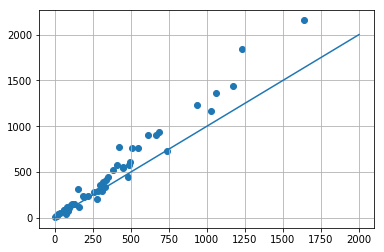